**<div align="center"><h1>Title: Hyperparameter Sizing with Computational Budget and sample sizes</h1></div>**





# **Objective**: <br>
## This notebook aims to explore the size of hyperparameters as a function of sample size and computational time budget. The goal of this internship is to establish a relationship between sample size, computational resources, and the ideal hyperparameter sizes for different models.

## **Step 1: Model Implementation**

### Import Libraries :

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
np.random.seed(5)
import time

### Define Functions :

In [ ]:
def true_function(x):
    return np.sin(2 * np.pi * x)

# the output will be piece wise constant
def partition_estimator_cst(Xtrain, ytrain, Xtest, Jcard):
    ftest = np.zeros(len(Xtest))
    bintest = np.ceil(Xtest * Jcard)
    bintest[bintest == 0] = 1
    bintrain = np.ceil(Xtrain * Jcard)
    bintrain[bintrain == 0] = 1

    for itest in range(len(Xtest)):
        x = Xtest[itest]
        bin_ = bintest[itest]
        ind = np.where(bintrain == bin_)[0]
        if len(ind) == 0:
            ftest[itest] = np.mean(ytrain)
        else:
            ftest[itest] = np.mean(ytrain[ind])

    return ftest
# The output is linear (linear splines) solving it bu least resgression
def partition_estimator_lst(Xtrain, ytrain, Xtest, Jcard):
    ftest = np.zeros(len(Xtest))
    bintest = np.ceil(Xtest * Jcard)
    bintest[bintest == 0] = 1
    bintrain = np.ceil(Xtrain * Jcard)
    bintrain[bintrain == 0] = 1

    for itest in range(len(Xtest)):
        x = Xtest[itest]
        bin_ = bintest[itest]
        ind = np.where(bintrain == bin_)[0]
        if len(ind) == 0:
            ftest[itest] = np.mean(ytrain)
        else:
            # Perform least-squares
            yloc = ytrain[ind]
            Xloc = np.hstack((Xtrain[ind], np.ones((len(ind), 1))))
            theta = np.linalg.lstsq(Xloc, yloc, rcond=None)[0]
            ftest[itest] = np.array([Xtest[itest], 1]).dot(theta)
    return ftest


### Generate Data

In [ ]:
np.random.seed(1)
n = 200
std_noise = 0.2
Xtrain = np.random.rand(n, 1)
Xtrain=np.sort(Xtrain)
def true_function(Xtrain):
    return np.sin(2 * np.pi * Xtrain)
ytrain = true_function(Xtrain) + std_noise * np.random.randn(n, 1)
Xtest = np.arange(0, 1, 0.01).reshape(-1, 1)
ytest = true_function(Xtest)


## **1- Partition estimator which called also regressogram**

<ipython-input-2-49ce327fd0d6>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ftest[itest] = np.array([Xtest[itest], 1]).dot(theta)


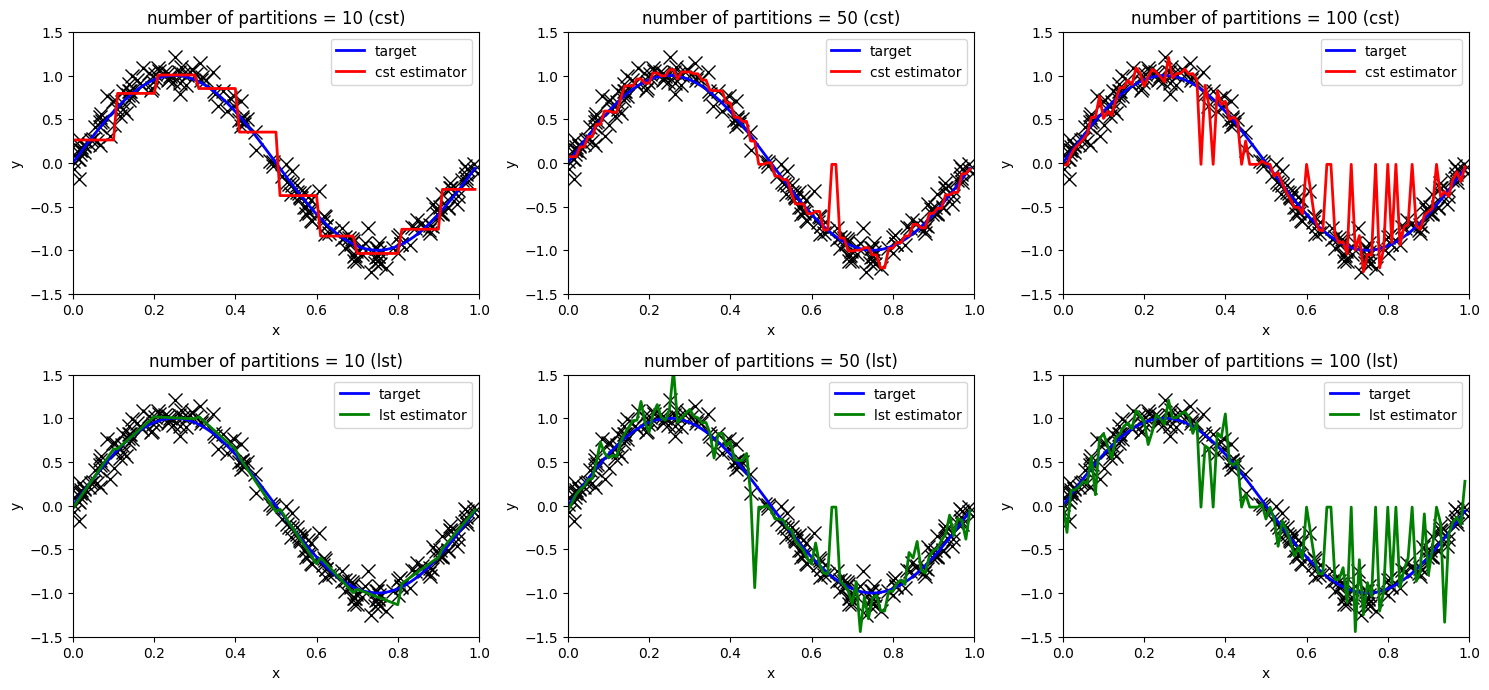

In [ ]:
Jcard_values = [10, 50, 100]
plt.figure(figsize=(15, 10))

for i, Jcard in enumerate(Jcard_values):
    # ftest1 plots (let's call it constant estimator as an example)
    ftest1 = partition_estimator_cst(Xtrain, ytrain, Xtest, Jcard)
    plt.subplot(len(Jcard_values), 3, i + 1)
    plt.plot(Xtrain, ytrain, 'xk', markersize=10)
    plt.plot(Xtest, ytest, 'b', linewidth=2, label='target')
    plt.plot(Xtest, ftest1, 'r', linewidth=2, label='cst estimator')
    plt.axis([0, 1, -1.5, 1.5])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'number of partitions = {Jcard} (cst)', fontweight='normal')
    plt.legend()
    ftest2 = partition_estimator_lst(Xtrain, ytrain, Xtest, Jcard)
    plt.subplot(len(Jcard_values), 3, i + 1 + len(Jcard_values))
    plt.plot(Xtrain, ytrain, 'xk', markersize=10)
    plt.plot(Xtest, ytest, 'b', linewidth=2, label='target')
    plt.plot(Xtest, ftest2, 'g', linewidth=2, label='lst estimator')
    plt.axis([0, 1, -1.5, 1.5])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'number of partitions = {Jcard} (lst)', fontweight='normal')
    plt.legend()

plt.tight_layout()
plt.show()

## **2- K-nearest neighbors**

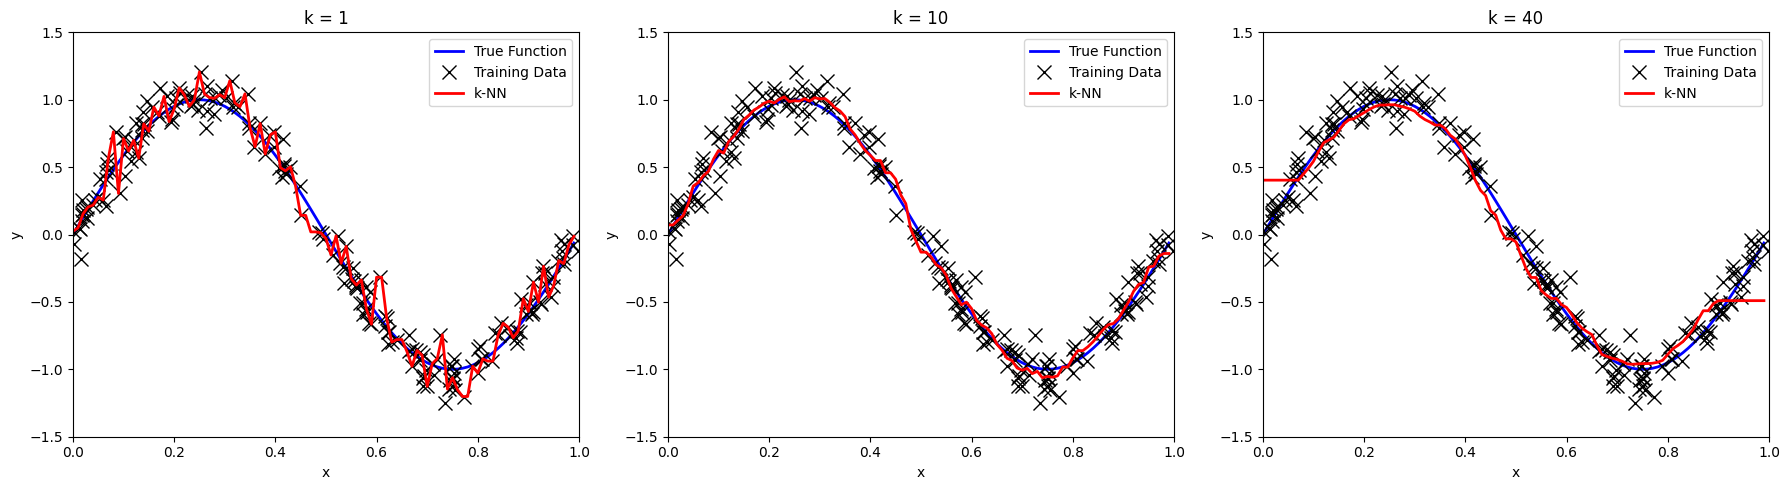

In [ ]:
K_values = [1,10,40]
plt.figure(figsize=(18, 5))
for i, k in enumerate(K_values):
    plt.subplot(1, 3, i+1)
    ftest = np.zeros(Xtest.shape[0])
    for itest in range(Xtest.shape[0]):
        x = Xtest[itest]
        b = np.argsort(np.abs(Xtrain - x), axis=0)
        ftest[itest] = np.mean(ytrain[b[:k]])

    # Plot true function, noisy training data, and k-NN estimates
    plt.plot(Xtest, ytest, 'b', linewidth=2, label='True Function')
    plt.plot(Xtrain, ytrain, 'xk', markersize=10, label='Training Data')
    plt.plot(Xtest, ftest, 'r', linewidth=2, label='k-NN')

    # Setting the axis, labels and title
    plt.axis([0, 1, -1.5, 1.5])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title(f'k = {k}', fontweight='normal')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# To show the plots
plt.tight_layout()
plt.show()

## **3- Nadarya Watson - Kernel regression**

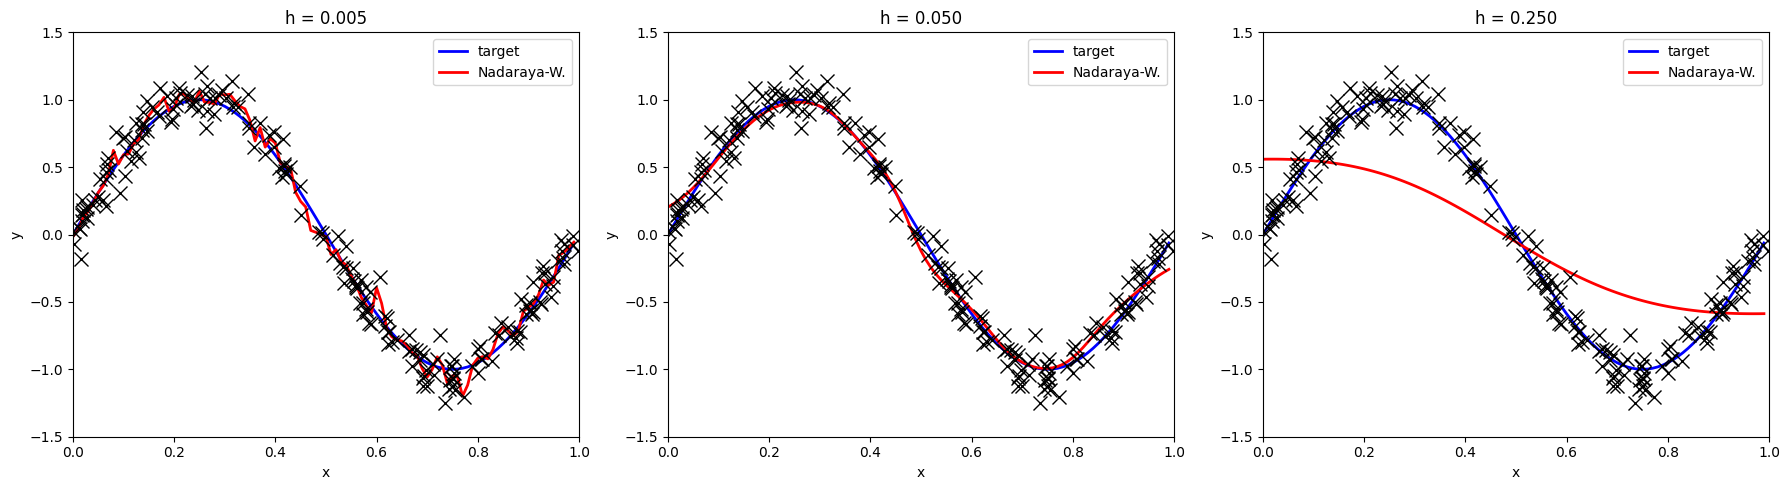

In [ ]:
def compute_ftest(Xtrain, ytrain, Xtest, h):
  ftest = np.zeros_like(Xtest)
  for itest in range(len(Xtest)):
      x = Xtest[itest]
      temp = np.exp(-((x - Xtrain)**2) / (2 * h * h))
      ftest[itest] = np.dot(temp.T, ytrain) / np.sum(temp)
  return ftest

# Set figure size and plot for different bandwidths
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

h_values = [0.005, 0.05, 0.25]
for i, h in enumerate(h_values):
    ftest = compute_ftest(Xtrain, ytrain, Xtest, h)

    ax[i].plot(Xtest, ytest, 'b', linewidth=2)
    ax[i].plot(Xtest, ftest, 'r', linewidth=2)
    ax[i].plot(Xtrain, ytrain, 'xk', markersize=10)
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([-1.5,1.5])
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_title(f'h = {h:.3f}', fontweight='normal')
    ax[i].legend(['target', 'Nadaraya-W.'])

plt.tight_layout()
plt.savefig("nadaraya_1D.png")
plt.show()

## **Step 2: Hyperparameter Sizing** <br>
### The best hyperparamter = $\arg \min_{\theta} \text{MSE}$  <br>
*where*

*    $\theta$ is the hyperparameter.
*   MSE : is the Mean squared error $$\cfrac{1}{N} \sum_{i=1}^{N} (\hat{f}_{\theta}(x_i)) - (f(x_i)+𝛆_i))^2$$



## **1- The hyperparameter in Partition estimator:**    $J_{card}$ (the number  of partitions) <br>
## **2- The hyperparameter in K Nearest Neighbors :**    $K$ (the number  of neighbors)<br>
## **3- The hyperparameter in Kernel regression :**    $h$ (the size of the kernel function)


# **Here is the first trail to approximate the function $f(x)=sin(2 \pi x)$** <br>  **by using Polynomial Approximation function**

Best Degree: 14


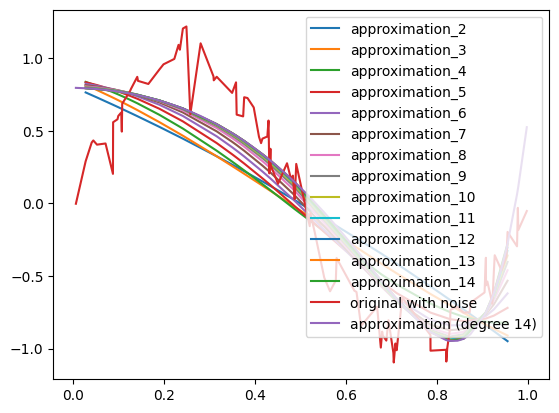

In [ ]:
N = 100
x = np.random.uniform(0, 1, N)
x = np.sort(x)
epsilon = np.random.normal(0, 0.1, N)
def true_function(x):
    return np.sin(2 * np.pi * x)
y = true_function(x) + epsilon

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

time_budget = 300
tt1 = time.time()
def polynomial_prediction(theta, x):
    degree = len(theta) - 1
    return np.polyval(theta[::-1], x)

def objective_function(theta, X, y):
    y_pred = polynomial_prediction(theta, X)
    difference = y- y_pred
    return np.linalg.norm(difference)**2 + 0.003* np.linalg.norm(theta)**2, y_pred

def gradient(theta, x, y):
    y_pred = polynomial_prediction(theta, x[1])
    grad = 2 *(y_pred - y) * x  + 2*0.003*theta
    return grad

def stochastic_gradient_descent(X, y, learning_rate=0.05, num_epochs=1000, batch_size=1):
    num_samples = X.shape[0]
    num_features = len(X[0])
    theta = np.zeros(num_features)

    for epoch in range(num_epochs):
        for i in range(0, num_samples, batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            gradient_sum = np.zeros(num_features)
            for j in range(len(X_batch)):
                gradient_sum += gradient(theta, X_batch[j], y_batch[j])
            gradient_avg = gradient_sum / batch_size
            theta -= learning_rate * gradient_avg

    return theta

best_degree = None
best_objective = float('inf')

for degree in range(1, 15):
    X_train = np.column_stack([x_train ** i for i in range(degree + 1)])
    optimal_theta = stochastic_gradient_descent(X_train, y_train)
    X_val = np.column_stack([x_val ** i for i in range(degree + 1)])
    objective_val, y_val_pred = objective_function(optimal_theta, X_val[:, 1], y_val)
    if degree > 1:
        plt.plot(x_val[np.argsort(x_val)], y_val_pred[np.argsort(x_val)], label="approximation_{}".format(degree))

    if objective_val < best_objective:
        best_objective = objective_val
        best_degree = degree

    tt2 = time.time()
    if tt2 - tt1 >= time_budget:
        print("Time budget exhausted after {:.2f} seconds.".format(tt2 - tt1))
        break

X_train = np.column_stack([x_train ** i for i in range(best_degree + 1)])
X_test = np.column_stack([x_val ** i for i in range(best_degree + 1)])
optimal_theta = stochastic_gradient_descent(X_train, y_train)
objective_test = objective_function(optimal_theta, X_test[:, 1], y_val)
print("Best Degree:", best_degree)
plt.plot(x, y, label="original with noise")
X_train_best = np.column_stack([x_train ** i for i in range(best_degree + 1)])
optimal_theta_best = stochastic_gradient_descent(X_train_best, y_train)
y_pred_best = polynomial_prediction(optimal_theta_best, x)
plt.plot(x, y_pred_best, label="approximation (degree {})".format(best_degree))
plt.legend()


# **Step 3: Time Complexity Analysis**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time

In [ ]:
sample_sizes = [100,1000,10000,20000,40000,60000,80000,100000,1000000] #for KNN
sample_sizes_p = [100,1000,10000,20000,40000,60000,80000,100000]
def generate_random_data(size):
    return np.random.rand(size), np.random.rand(size), np.random.rand(size)

In [ ]:
def partition_estimator_lst(Xtrain, ytrain, Xtest, Jcard):
    ftest = np.zeros(len(Xtest))
    bintest = np.ceil(Xtest * Jcard)
    bintest[bintest == 0] = 1
    bintrain = np.ceil(Xtrain * Jcard)
    bintrain[bintrain == 0] = 1

    for itest in range(len(Xtest)):
        x = Xtest[itest]
        bin_ = bintest[itest]
        ind = np.where(bintrain == bin_)[0]
        if len(ind) == 0:
            ftest[itest] = np.mean(ytrain)
        else:
            # Perform least-squares
            yloc = ytrain[ind]
            Xloc = np.hstack((Xtrain[ind].reshape(-1, 1), np.ones((len(ind), 1))))
            theta = np.linalg.lstsq(Xloc, yloc, rcond=None)[0]
            ftest[itest] = np.array([Xtest[itest], 1]).dot(theta)
    return ftest

In [ ]:
def knn_estimator(x_train, y_train, x_validation, k):
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(x_train.reshape(-1, 1), y_train)
    y_pred = knn_model.predict(x_validation.reshape(-1, 1))
    return y_pred

In [ ]:
def kernel_estimator(Xtrain, ytrain, Xtest, h):
  ftest = np.zeros_like(Xtest)
  for itest in range(len(Xtest)):
      x = Xtest[itest]
      temp = np.exp(-((x - Xtrain)**2) / (2 * (h**2)))
      ftest[itest] = np.dot(temp.T, ytrain) / np.sum(temp)
  return ftest

In [ ]:
def measure_time(func, *args):
    start_time = time.time()
    func(*args)
    end_time = time.time()
    return end_time - start_time

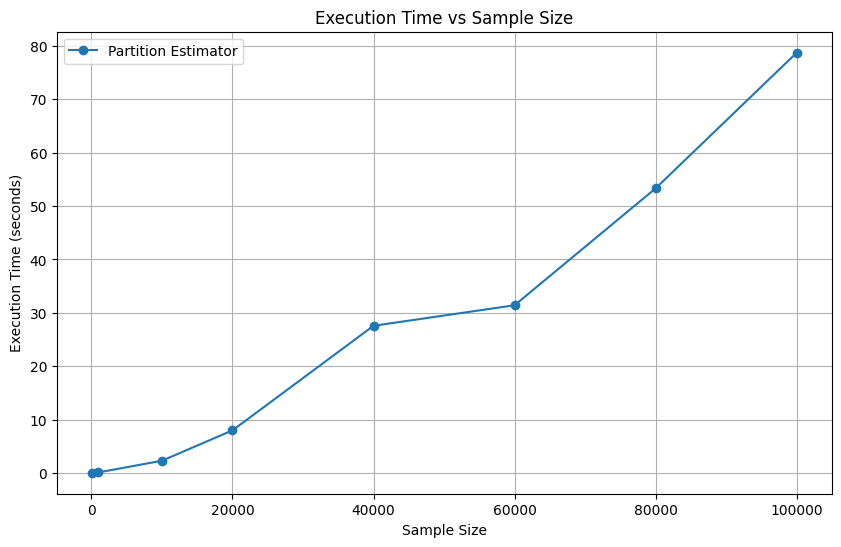

In [ ]:
execution_times_partition = []
for size in sample_sizes_p:
    Xtrain, ytrain, Xtest = generate_random_data(size)
    execution_times_partition.append(measure_time(partition_estimator_lst, Xtrain, ytrain, Xtest, 10))
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes_p, execution_times_partition, '-o', label='Partition Estimator')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Sample Size')
plt.legend()
plt.grid(True)
plt.show()



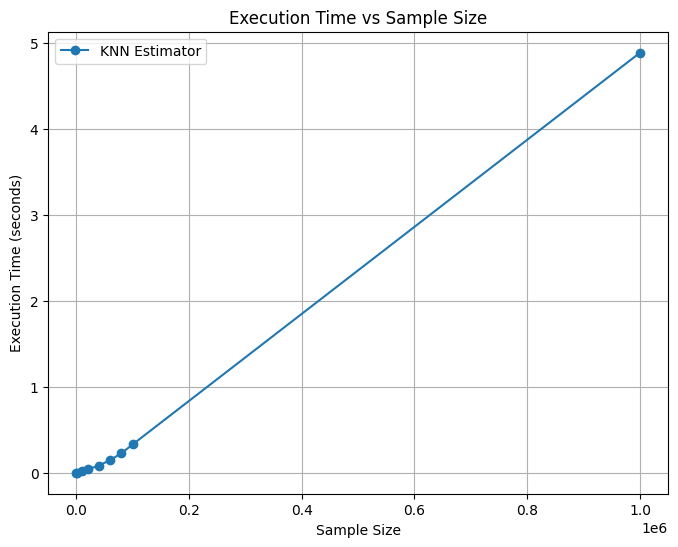

In [ ]:
execution_times_knn = []
for size in sample_sizes:
    Xtrain, ytrain, Xtest = generate_random_data(size)
    execution_times_knn.append(measure_time(knn_estimator, Xtrain, ytrain, Xtest, 5))
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, execution_times_knn, '-o', label='KNN Estimator')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Sample Size')
plt.legend()
plt.grid(True)
plt.show()

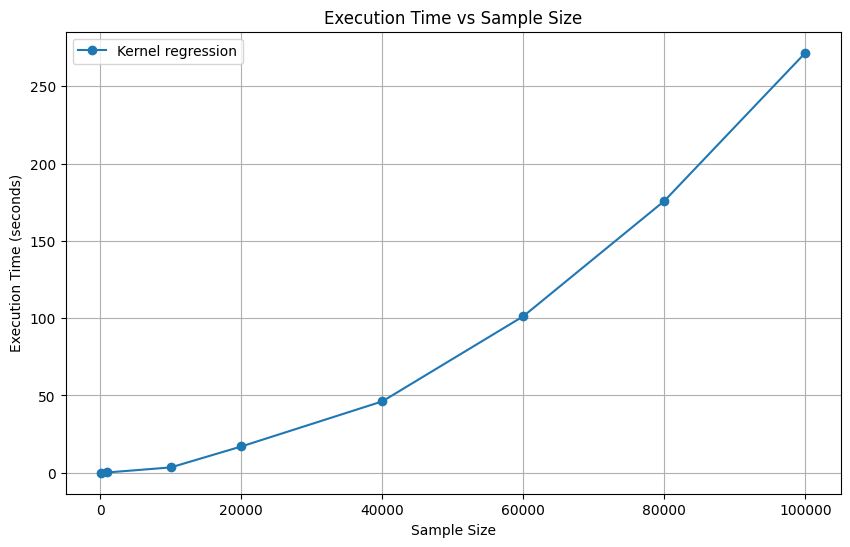

In [ ]:
execution_times_kernel = []
for size in sample_sizes_p:
    Xtrain, ytrain, Xtest = generate_random_data(size)
    execution_times_kernel.append(measure_time(kernel_estimator, Xtrain, ytrain, Xtest, 10))
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes_p, execution_times_kernel, '-o', label='Kernel regression')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Sample Size')
plt.legend()
plt.grid(True)
plt.show()

# **Step 4: Results and Discussion**

## **1- Define**
*   The sample size.
*   Validation set size.
*   The standard deviation.
*   Scaling list





In [ ]:
sample_sizes = [30,100,300,1000,3000,10000,30000]
sample_sizes_ct = [10,1000,10000]
scale_list = [0.1, 0.2, 0.5, 1, 2,3,4]
validation_size = 0.3
sigma = 0.2


# **1- Partition estimator(with Least Squares regression)**


In [ ]:
# The output is linear (linear splines) solving it bu least resgression
def partition_estimator_lst(Xtrain, ytrain, Xtest, Jcard):
    ftest = np.zeros(len(Xtest))
    bintest = np.ceil(Xtest * Jcard)
    bintest[bintest == 0] = 1
    bintrain = np.ceil(Xtrain * Jcard)
    bintrain[bintrain == 0] = 1

    for itest in range(len(Xtest)):
        x = Xtest[itest]
        bin_ = bintest[itest]
        ind = np.where(bintrain == bin_)[0]
        if len(ind) == 0:
            ftest[itest] = np.mean(ytrain)
        else:
            # Perform least-squares
            yloc = ytrain[ind]
            Xloc = np.hstack((Xtrain[ind], np.ones((len(ind), 1))))
            theta = np.linalg.lstsq(Xloc, yloc, rcond=None)[0]
            ftest[itest] = np.array([Xtest[itest], 1]).dot(theta)
    return ftest

def distance_function_lst(x, y, J, f_star, n_mc):
    x_mc = np.random.rand(n_mc,1)
    f_hat = partition_estimator_lst(x, y, x_mc, J)
    distance = np.mean((np.abs(f_hat - f_star(x_mc)))**2)
    return distance
def MSE(fhat, x_valid, y_valid):
    mse = np.mean((np.abs(fhat - y_valid))**2)
    return mse



true_theoretical_J 4 J_list [ 1  2  4  8 12 16]


<ipython-input-17-7556a7a1d245>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ftest[itest] = np.array([Xtest[itest], 1]).dot(theta)


For sample size 30, J_t : 4,best no. of partitons =:4,best MSE : 0.0495249268774144,min distance : 0.032621177051971595 
true_theoretical_J 6 J_list [ 1  3  6 12 18 24]
For sample size 100, J_t : 6,best no. of partitons =:6,best MSE : 0.05226948291160258,min distance : 0.007255073429705665 
true_theoretical_J 9 J_list [ 1  2  4  9 18 27 36]
For sample size 300, J_t : 9,best no. of partitons =:9,best MSE : 0.042913372294817516,min distance : 0.003906806711616087 
true_theoretical_J 13 J_list [ 1  3  6 13 26 39 52]
For sample size 1000, J_t : 13,best no. of partitons =:13,best MSE : 0.03993734323676145,min distance : 0.0016195805085254583 
true_theoretical_J 19 J_list [ 2  4 10 19 38 57 76]
For sample size 3000, J_t : 19,best no. of partitons =:10,best MSE : 0.03919261155516899,min distance : 0.00033214653199467673 
true_theoretical_J 29 J_list [  3   6  14  29  58  87 116]
For sample size 10000, J_t : 29,best no. of partitons =:29,best MSE : 0.03978568768998052,min distance : 0.00021765

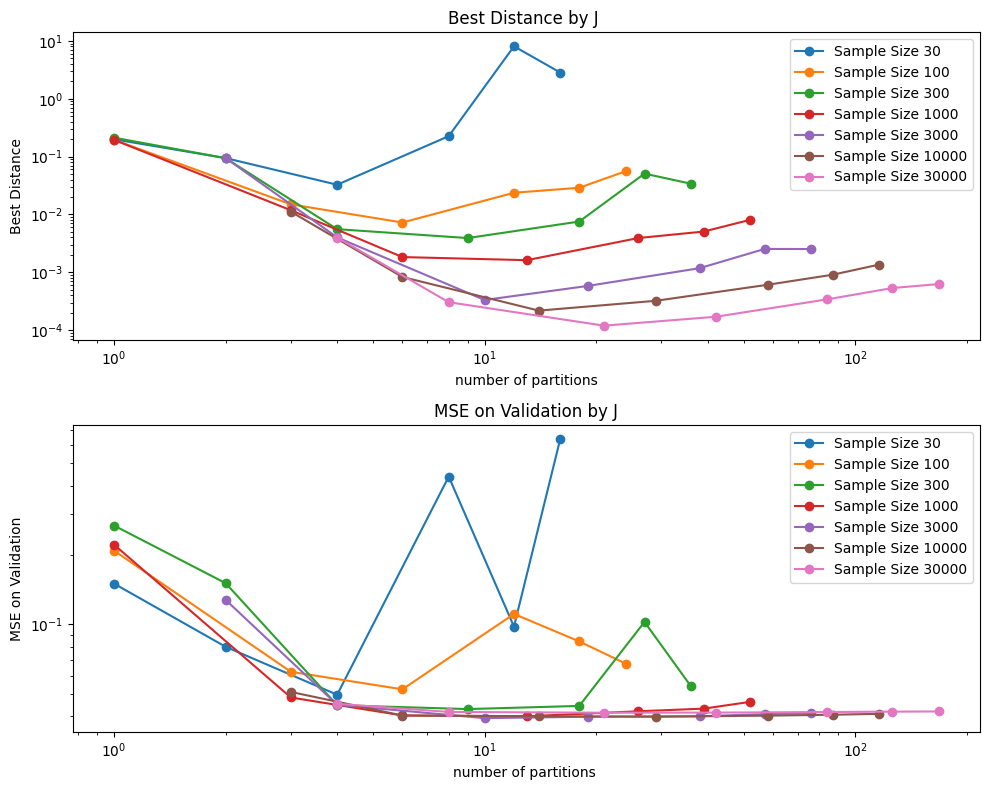

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
result_table = []
for n in (sample_sizes):
    results = {}
    true_theoretical_J = round((4*n/(16*(sigma**2) +1 ))**(1/3))
    J_list = [round(true_theoretical_J * scale) for scale in scale_list if round(true_theoretical_J * scale) < n*(1-validation_size) and round(true_theoretical_J * scale) != 0]
    J_list = np.unique(J_list)
    print('true_theoretical_J',true_theoretical_J,'J_list',J_list)
    best_mse = float('inf')
    best_p = float('inf')
    x = np.random.rand(n,1)
    eps = np.random.normal(0,sigma, n)
    f_star = lambda x_ : np.sin(2*np.pi*x_.ravel())
    y = f_star(x) + eps
    x, x_validation, y, y_validation = train_test_split(x, y, test_size=validation_size)
    best_mses = []
    best_hyperparams = []
    for J in J_list:
        time_start = time.time()
        f_validation = partition_estimator_lst(x, y, x_validation, J)
        mse = MSE(f_validation, x_validation, y_validation)
        time_end = time.time()
        T = time_end-time_start
        distance = distance_function_lst(x, y, J, f_star, 1000)
        if mse < best_mse:
            best_mse = mse
            best_p = J
        c_t = T / (n**2)
        results[J] = distance
        result_table.append({
            "Sample Size": n,
            "Partition Size": J,
            "Best J": best_p,
            "T": T,
            "c_t": c_t,
            "Distance": distance,
            "MSE": mse,
        })
        best_mses.append(mse)
        best_hyperparams.append(J)
    J_values = list(results.keys())
    distances = list(results.values())
    min_J = min(results, key=results.get)
    min_distance = results[min_J]
    print(f"For sample size {n}, J_t : {true_theoretical_J},best no. of partitons =:{best_p},best MSE : {best_mse},min distance : {min_distance} ")
    ax[0].loglog(J_values, distances, marker='o', label=f'Sample Size {n}')
    ax[1].loglog(best_hyperparams, best_mses, marker='o', label=f'Sample Size {n}')

ax[0].set_xlabel('number of partitions')
ax[0].set_ylabel('Best Distance')
ax[0].set_title('Best Distance by J ')
ax[0].legend()
ax[1].set_xlabel('number of partitions ')
ax[1].set_ylabel('MSE on Validation')
ax[1].set_title('MSE on Validation by J')
ax[1].legend()
plt.tight_layout()
plt.show()
result_table = pd.DataFrame(result_table).sort_values('Sample Size')

In [ ]:
result_table['c_t']
pscale_factor = np.mean(c_t)
print(pscale_factor)
Time_budget = 1
pNew_scale_list = [Time_budget /(pscale_factor  * (n**2)) for  n in sample_sizes]
print(pNew_scale_list)

2.0000473658243815e-09
[555542.398693709, 49998.81588243381, 5555.42398693709, 499.9881588243381, 55.55423986937091, 4.999881588243381, 0.555542398693709]


## **Here we modify the B constant in J_theory value**

no. of partitions with B= 0.05 is 1.0
J_(not theory) exists


<ipython-input-17-7556a7a1d245>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ftest[itest] = np.array([Xtest[itest], 1]).dot(theta)


best no. of partitions 22.0 that corresponds the MSE = 0.03128208579937526
For sample size 30, the lowest distance is: 0.014718133269908376, corresponding to J = 5.0
no. of partitions with B= 0.05 is 2.0
J_(not theory) exists
best no. of partitions 8.0 that corresponds the MSE = 0.03610836192965244
For sample size 100, the lowest distance is: 0.00833128071136646, corresponding to J = 6.0
no. of partitions with B= 0.05 is 2.0
J_(not theory) exists
best no. of partitions 7.0 that corresponds the MSE = 0.0709669143599887
For sample size 300, the lowest distance is: 0.002607308344696399, corresponding to J = 8.0
no. of partitions with B= 0.05 is 3.0
J_(not theory) exists
best no. of partitions 7.0 that corresponds the MSE = 0.03742657176730171
For sample size 1000, the lowest distance is: 0.0012412079984221922, corresponding to J = 9.0
no. of partitions with B= 0.05 is 4.0
J_(not theory) exists
best no. of partitions 11.0 that corresponds the MSE = 0.04064788931832955
For sample size 3000,

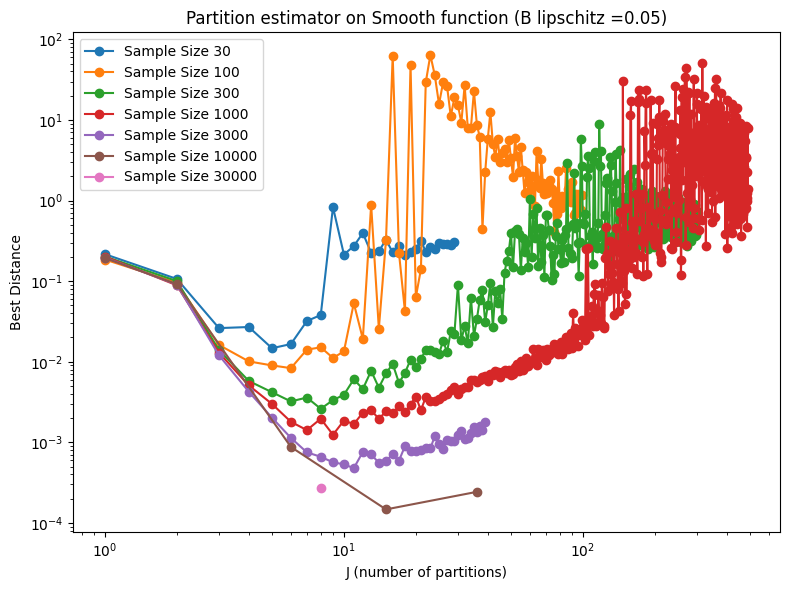

In [ ]:
import tqdm as tqdm
fig, ax = plt.subplots(figsize=(8, 6))
B = 0.05
for idx, n in enumerate(sample_sizes):
    x = np.random.rand(n, 1)
    eps = np.random.normal(0, sigma, n)
    f_star = lambda x_: np.sin(2 * np.pi * x_.ravel())
    y = f_star(x) + eps
    x, x_validation, y, y_validation = train_test_split(x, y, test_size=validation_size)
    scale_ = int(np.ceil(pNew_scale_list[idx]))
    results = {}
    not_so_theoretical_J = np.ceil((4 * (B ** 2) * n / (16 * (sigma ** 2) + B ** 2)) ** (1 / 3))
    print('no. of partitions with B=',B,'is', not_so_theoretical_J)
    partition_estimator_lst(x, y, x_validation, not_so_theoretical_J)
    J_list_log = np.linspace(0,2* np.log(not_so_theoretical_J),num=scale_)
    J_list = np.unique(np.round(np.exp(J_list_log)))
    if len(J_list) < scale_:
      J_list = np.concatenate((J_list,np.arange(2,min(scale_-len(J_list),n))))
      J_list = np.unique(J_list)
      #print('J_list_merged',J_list)
    if len(J_list)==1:
      J_list=[not_so_theoretical_J]
    if not_so_theoretical_J in J_list:
     print('J_(not theory) exists')
    best_hyperparams_for_n = []
    best_mse = float('inf')
    best_mses = []
    best_hyperparams = []
    for J in J_list:
        time_start = time.time()
        f_validation = partition_estimator_lst(x, y, x_validation, J)
        mse = MSE(f_validation, x_validation, y_validation)
        time_end = time.time()
        T = time_end - time_start
        distance = distance_function_lst(x, y, J, f_star, 1000)
        if mse < best_mse:
            best_mse = mse
            best_p=J
        results[J] = distance
        best_mses.append(mse)
        best_hyperparams.append(J)
    print('best no. of partitions',best_p,'that corresponds the MSE =',best_mse)
    J_values = list(results.keys())
    distances = list(results.values())
    min_distance, corresponding_J = min(zip(distances, J_values))  # Finds the minimum distance and its corresponding J value
    print(f"For sample size {n}, the lowest distance is: {min_distance}, corresponding to J = {corresponding_J}")
    ax.loglog(J_values, distances, marker='o', label=f'Sample Size {n}')
ax.set_xlabel('J (number of partitions)')
ax.set_ylabel('Best Distance')
ax.set_title('Partition estimator on Smooth function (B lipschitz =0.05)')
ax.legend()
plt.tight_layout()
plt.show()


J with B lipschtz= 100 5
J_(not theory) exists


<ipython-input-17-7556a7a1d245>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ftest[itest] = np.array([Xtest[itest], 1]).dot(theta)


best no. of partitions 3.0 that corresponds the MSE = 0.03914575066789888
For sample size 30, the lowest distance is: 0.018377157138884916, corresponding to J = 3.0
J with B lipschtz= 100 7
J_(not theory) exists
best no. of partitions 5.0 that corresponds the MSE = 0.051720591352742366
For sample size 100, the lowest distance is: 0.005811193292518832, corresponding to J = 6.0
J with B lipschtz= 100 11
J_(not theory) exists
best no. of partitions 7.0 that corresponds the MSE = 0.040761791939947764
For sample size 300, the lowest distance is: 0.0028469514551288065, corresponding to J = 7.0
J with B lipschtz= 100 16
J_(not theory) exists
best no. of partitions 7.0 that corresponds the MSE = 0.03577879598758347
For sample size 1000, the lowest distance is: 0.0009076151773675933, corresponding to J = 11.0
J with B lipschtz= 100 23
best no. of partitions 9.0 that corresponds the MSE = 0.03789457955684255
For sample size 3000, the lowest distance is: 0.00037912241201030366, corresponding to J

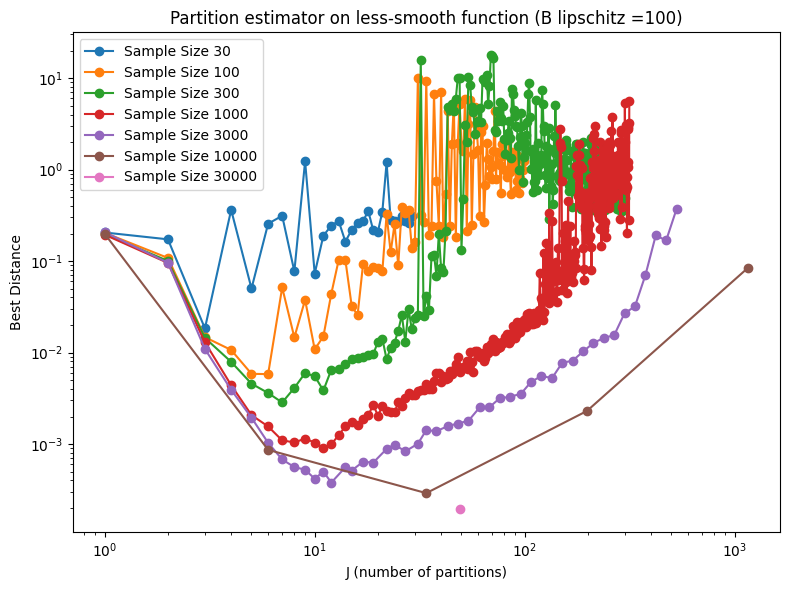

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
B = 100
for idx, n in enumerate(sample_sizes):
  x = np.random.rand(n, 1)
  eps = np.random.normal(0, sigma, n)
  f_star = lambda x_: np.sin(2 * np.pi * x_.ravel())
  y = f_star(x) + eps
  x, x_validation, y, y_validation = train_test_split(x, y, test_size=validation_size)
  scale_ = int(np.ceil(pNew_scale_list[idx]))
  results = {}
  not_so_theoretical_J = round((4 * (B ** 2) * n / (16 * (sigma ** 2) + B ** 2)) ** (1 / 3))
  print('J with B lipschtz= 100', not_so_theoretical_J)
  partition_estimator_lst(x, y, x_validation, not_so_theoretical_J)
  J_list_log = np.linspace(0,2* np.log(not_so_theoretical_J),num=scale_)
  J_list = np.unique(np.round(np.exp(J_list_log)))
  if len(J_list) < scale_:
    J_list = np.concatenate((J_list,np.arange(2,min(scale_-len(J_list),n))))
    J_list = np.unique(J_list)
    #print('J_list_merged',J_list)
  if len(J_list)==1:
    J_list=[not_so_theoretical_J]
  if not_so_theoretical_J in J_list:
    print('J_(not theory) exists')
  best_mse = float('inf')
  best_mses = []
  best_hyperparams = []
  for J in J_list:
      time_start = time.time()
      f_validation = partition_estimator_lst(x, y, x_validation, J)
      mse = MSE(f_validation, x_validation, y_validation)
      time_end = time.time()
      T = time_end - time_start
      distance = distance_function_lst(x, y, J, f_star, 1000)
      if mse < best_mse:
          best_mse = mse
          best_p = J
      results[J] = distance
      best_mses.append(mse)
      best_hyperparams.append(J)
  print('best no. of partitions',best_p,'that corresponds the MSE =',best_mse)
  J_values = list(results.keys())
  distances = list(results.values())
  min_distance, corresponding_J = min(zip(distances, J_values))  # Finds the minimum distance and its corresponding J value
  print(f"For sample size {n}, the lowest distance is: {min_distance}, corresponding to J = {corresponding_J}")
  ax.loglog(J_values, distances, marker='o', label=f'Sample Size {n}')
ax.set_xlabel('J (number of partitions)')
ax.set_ylabel('Best Distance')
ax.set_title('Partition estimator on less-smooth function (B lipschitz =100)')
ax.legend()
plt.tight_layout()
plt.show()

# **2- K Nearest Neighbors**


In [ ]:
def knn_estimator(x_train, y_train, x_validation, k):
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(x_train.reshape(-1, 1), y_train)
    y_pred = knn_model.predict(x_validation.reshape(-1, 1))
    return y_pred

def distance_function_knn(x, y, k, f_star, n_mc):
    x_mc = np.random.rand(n_mc, 1)
    y_pred = knn_estimator(x, y,x_mc, k)
    distance = np.mean((np.abs(y_pred - f_star(x_mc)))**2)
    return distance
#Monte Carlo method
def MSE(fhat, x_valid, y_valid):
    mse = np.mean((np.abs(fhat - y_valid))**2)
    return mse

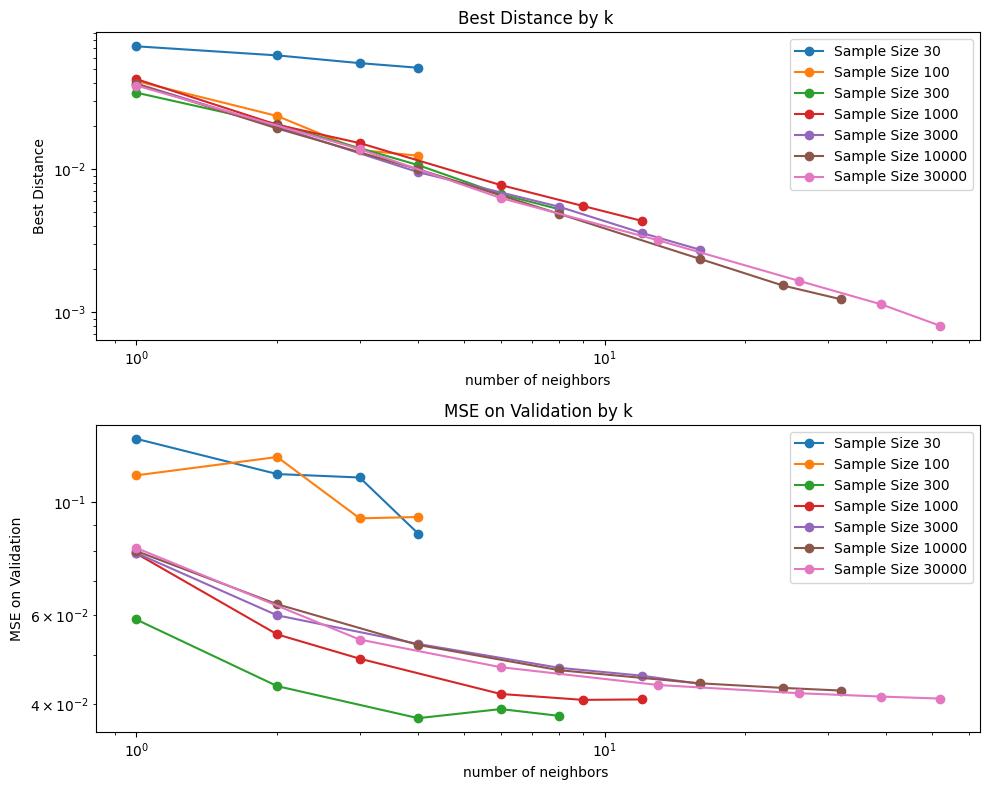

In [ ]:
result_table_knn = []
fig, ax = plt.subplots(2, 1, figsize=(10,8))
for n in (sample_sizes):
    results = {}
    true_theoretical_k = np.ceil((((sigma**2) * n)/(8))**(1/2))
    k_list = [ round(true_theoretical_k * scale) for scale in scale_list if round(true_theoretical_k * scale) < n*(1-validation_size)  and round(true_theoretical_k * scale) != 0]
    k_list = np.unique(k_list)
    best_mse = float('inf')
    best_k = float('inf')
    x = np.random.rand(n,1)
    eps = np.random.normal(0,sigma, n)
    f_star = lambda x_ : np.sin(2*np.pi*x_.ravel())
    y = f_star(x) + eps
    x, x_validation, y, y_validation = train_test_split(x, y, test_size=validation_size)
    best_mses = []
    best_hyperparams = []
    for k in k_list:
        time_start = time.time()
        f_kvalidation = knn_estimator(x, y, x_validation, k)
        mse = MSE(f_kvalidation, x_validation, y_validation)
        time_end = time.time()
        T = time_end-time_start
        distance = distance_function_knn(x, y, k, f_star, 1000)
        if mse < best_mse:
            best_mse = mse
            best_k = k
        c_t = T / (n*np.log(n))
        results[k] = distance
        result_table_knn.append({
            "Sample Size": n,
            "Partition Size": k,
            "Best J": best_k,
            "T": T,
            "c_t": c_t,
            "Distance": distance,
            "MSE": mse,
        })
        best_mses.append(mse)
        best_hyperparams.append(k)
    k_values = list(results.keys())
    distances = list(results.values())
    min_k = min(results, key=results.get)
    min_distance = results[min_k]
    #print(f"For sample size {n}, k_t : {true_theoretical_k}, k_p= {min_k}, min distance = {min_distance} ")
    ax[0].loglog(k_values, distances, marker='o', label=f'Sample Size {n}')
    ax[1].loglog(best_hyperparams, best_mses, marker='o', label=f'Sample Size {n}')

ax[0].set_xlabel('number of neighbors')
ax[0].set_ylabel('Best Distance')
ax[0].set_title('Best Distance by k ')
ax[0].legend()
ax[1].set_xlabel('number of neighbors ')
ax[1].set_ylabel('MSE on Validation')
ax[1].set_title('MSE on Validation by k')
ax[1].legend()
plt.tight_layout()
plt.show()
result_table_knn = pd.DataFrame(result_table_knn).sort_values('Sample Size')

In [ ]:
result_table_knn['c_t']
k_factor = np.mean(c_t)
Time_budget=1
print(k_factor)
New_scale_listk = [Time_budget /(k_factor  * (n*np.log(n))) for  n in sample_sizes]
print(New_scale_listk)
print(len(New_scale_listk))

2.5044974155107893e-07
[39131.48428826817, 8670.292075639414, 2333.4322880157483, 578.0194717092944, 166.23506325087772, 43.351460378197075, 12.910516352443247]
7


k_(not theory) exists
for N= 30  best no of neighbors 1.0 with best MSE= 0.09263708653351992 with Best distance {0.043765784801877136}
k_(not theory) exists
for N= 100  best no of neighbors 7.0 with best MSE= 0.02569442177193813 with Best distance {0.008543816370315505}
k_(not theory) exists
for N= 300  best no of neighbors 13.0 with best MSE= 0.045447207576738355 with Best distance {0.0038541671675734524}
k_(not theory) exists
for N= 1000  best no of neighbors 42.0 with best MSE= 0.03935157078794371 with Best distance {0.001371569203724917}
for N= 3000  best no of neighbors 65.0 with best MSE= 0.03899094904947861 with Best distance {0.00041700631340150975}
k_(not theory) exists
for N= 10000  best no of neighbors 180.0 with best MSE= 0.04080225276120442 with Best distance {0.00027951441985416616}
for N= 30000  best no of neighbors 404.0 with best MSE= 0.03983426235679929 with Best distance {0.00010106450056228633}


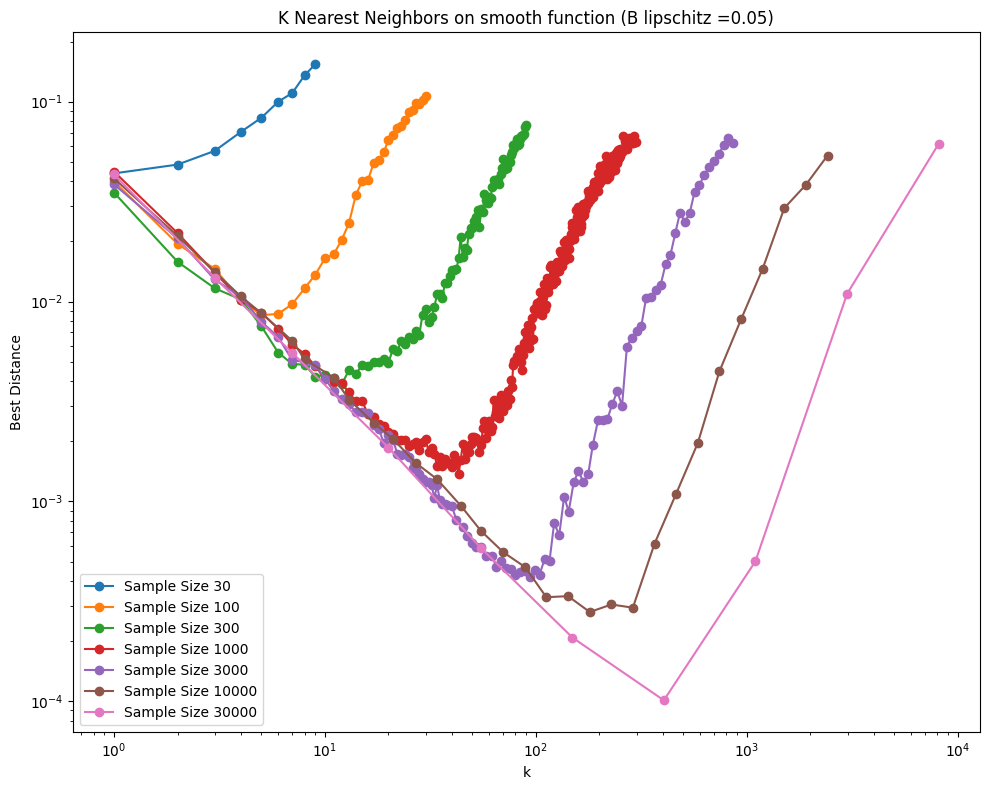

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
for idx, n in enumerate(sample_sizes):
    scale_ = int(New_scale_listk[idx])
    results = {}
    B=0.05
    not_so_theoretical_k = int(np.ceil(((sigma**2)*n/(8*(B**2)))**(1/2)))
    #print('not_so_theoretical_k',not_so_theoretical_k)
    x = np.random.rand(n,1)
    eps = np.random.normal(0,sigma, n)
    f_star = lambda x_ : np.sin(2*np.pi*x_.ravel())
    y = f_star(x) + eps
    x, x_validation, y, y_validation = train_test_split(x, y, test_size= validation_size)
    knn_estimator(x, y, x_validation, not_so_theoretical_k)
    k_list_log = np.linspace(0,2* np.log(not_so_theoretical_k),num=scale_)
    k_list = np.unique(np.round(np.exp(k_list_log)))
    if len(k_list) < scale_:
      k_list = np.concatenate((k_list,np.arange(2,min(scale_-len(k_list),n))))
      k_list = np.unique(k_list)
      #print('J_list_merged',J_list)
    if len(k_list) <=44:
      k_list=k_list
    if not_so_theoretical_k in k_list:
      print('k_(not theory) exists')
    best_mse = float('inf')
    best_mses = []
    best_hyperparams = []
    for k in k_list:
       if k <= len(x_validation):
        time_start = time.time()
        fk_validation = knn_estimator(x, y, x_validation, int(k))
        mse = MSE(fk_validation, x_validation, y_validation)
        time_end = time.time()
        T = time_end - time_start
        distance = distance_function_knn(x, y, int(k), f_star, 1000)
        if mse < best_mse:
            best_mse = mse
            best_k = k
        results[k] = distance
        # print(len(list(results.keys())))
        best_mses.append(mse)
        best_hyperparams.append(k)
    k_values = list(results.keys())
    distances = list(results.values())
    min_distance, corresponding_k = min(zip(distances, k_values))
    print('for N=',n,' best no of neighbors',best_k,'with best MSE=',best_mse,'with Best distance',{min_distance})
    ax.loglog(k_values, distances, marker='o', label=f'Sample Size {n}')
ax.set_xlabel('k')
ax.set_ylabel('Best Distance')
ax.set_title('K Nearest Neighbors on smooth function (B lipschitz =0.05)')
ax.legend()
plt.tight_layout()
plt.show()

k_(not theory) exists
for N= 30  best no of neighbors 5.0 with best MSE= 0.02968968091237924 with Best distance 0.03967836577515338
k_(not theory) exists
for N= 100  best no of neighbors 6.0 with best MSE= 0.052399141615905136 with Best distance 0.00995130487235153
k_(not theory) exists
for N= 300  best no of neighbors 22.0 with best MSE= 0.04440066590845202 with Best distance 0.004526291471326014
k_(not theory) exists
for N= 1000  best no of neighbors 20.0 with best MSE= 0.04062673125350153 with Best distance 0.0019229673945974134
k_(not theory) exists
for N= 3000  best no of neighbors 95.0 with best MSE= 0.043224599150241384 with Best distance 0.00036486236911470037
k_(not theory) exists
for N= 10000  best no of neighbors 41.0 with best MSE= 0.04084942569122955 with Best distance 0.0008928260605251025
k_(not theory) exists
for N= 30000  best no of neighbors 10.0 with best MSE= 0.04467138095892678 with Best distance 0.0041363975051224985


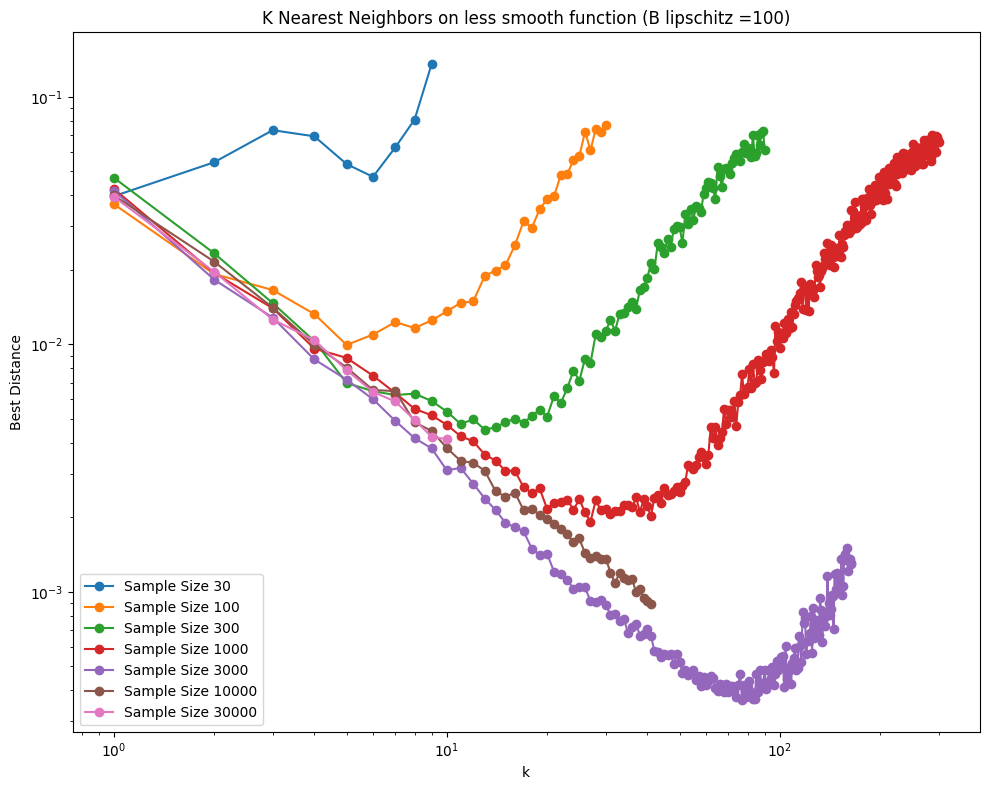

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
for idx, n in enumerate(sample_sizes):
    scale_ = int(New_scale_listk[idx])
    results = {}
    B=100
    not_so_theoretical_k = int(np.ceil(((sigma**2)*n/(8*(B**2)))**(1/2)))
    #print('not_so_theoretical_k',not_so_theoretical_k)
    x = np.random.rand(n,1)
    eps = np.random.normal(0,sigma, n)
    f_star = lambda x_ : np.sin(2*np.pi*x_.ravel())
    y = f_star(x) + eps
    x, x_validation, y, y_validation = train_test_split(x, y, test_size= validation_size)
    knn_estimator(x, y, x_validation, not_so_theoretical_k)
    k_list_log = np.linspace(0,2* np.log(not_so_theoretical_k),num=scale_)
    k_list = np.unique(np.round(np.exp(k_list_log)))
    if len(k_list) < scale_:
      k_list = np.concatenate((k_list,np.arange(2,min(scale_-len(k_list),n))))
      k_list = np.unique(k_list)
      #print('J_list_merged',J_list)
    if len(k_list)==1:
      k_list=[not_so_theoretical_J]
    if not_so_theoretical_k in k_list:
      print('k_(not theory) exists')
    best_mse = float('inf')
    best_mses = []
    best_hyperparams = []
    for k in k_list:
       if k <= len(x_validation):
        time_start = time.time()
        fk_validation = knn_estimator(x, y, x_validation, int(k))
        mse = MSE(fk_validation, x_validation, y_validation)
        time_end = time.time()
        T = time_end - time_start
        distance = distance_function_knn(x, y, int(k), f_star, 1000)
        if mse < best_mse:
            best_mse = mse
            best_k = k
        results[k] = distance
        # print(len(list(results.keys())))
        best_mses.append(mse)
        best_hyperparams.append(k)
    k_values = list(results.keys())
    distances = list(results.values())
    min_distance, corresponding_k = min(zip(distances, k_values))
    print('for N=',n,' best no of neighbors',best_k,'with best MSE=',best_mse,'with Best distance',min_distance)
    ax.loglog(k_values, distances, marker='o', label=f'Sample Size {n}')
ax.set_xlabel('k')
ax.set_ylabel('Best Distance')
ax.set_title('K Nearest Neighbors on less smooth function (B lipschitz =100)')
ax.legend()
plt.tight_layout()
plt.show()

# **3- Kernel regression**
## I started with this model, but due to time limitations, I didn't have the time to achieve the expected results from it (I will continue to work on this later).


In [ ]:
def kernel_estimator(Xtrain, ytrain, Xtest, h):
  ftest = np.zeros_like(Xtest)
  for itest in range(len(Xtest)):
      x = Xtest[itest]
      temp = np.exp(-((x - Xtrain)**2) / (2 * (h**2)))
      ftest[itest] = np.dot(temp.T, ytrain) / np.sum(temp)
  return ftest
def MSE(fhat, x_valid, y_valid):
    mse = np.mean((np.abs(fhat - y_valid))**2)
    return mse

def distance_function_kernel(x, y, h, f_star, n_mc):
    x_mc = np.random.rand(n_mc,1)
    f_hat = kernel_estimator(x, y, x_mc, h)
    distance = np.mean((np.abs(f_hat - f_star(x_mc)))**2)
    return distance

true_theoretical_h 0.22874087259616058 h_list [0.02287409 0.04574817 0.11437044 0.22874087 0.45748175 0.68622262
 0.91496349]
true_theoretical_h 0.14409772017761202 h_list [0.01440977 0.02881954 0.07204886 0.14409772 0.28819544 0.43229316
 0.57639088]
true_theoretical_h 0.10617210800331822 h_list [0.01061721 0.02123442 0.05308605 0.10617211 0.21234422 0.31851632
 0.42468843]
true_theoretical_h 0.07361562810567394 h_list [0.00736156 0.01472313 0.03680781 0.07361563 0.14723126 0.22084688
 0.29446251]


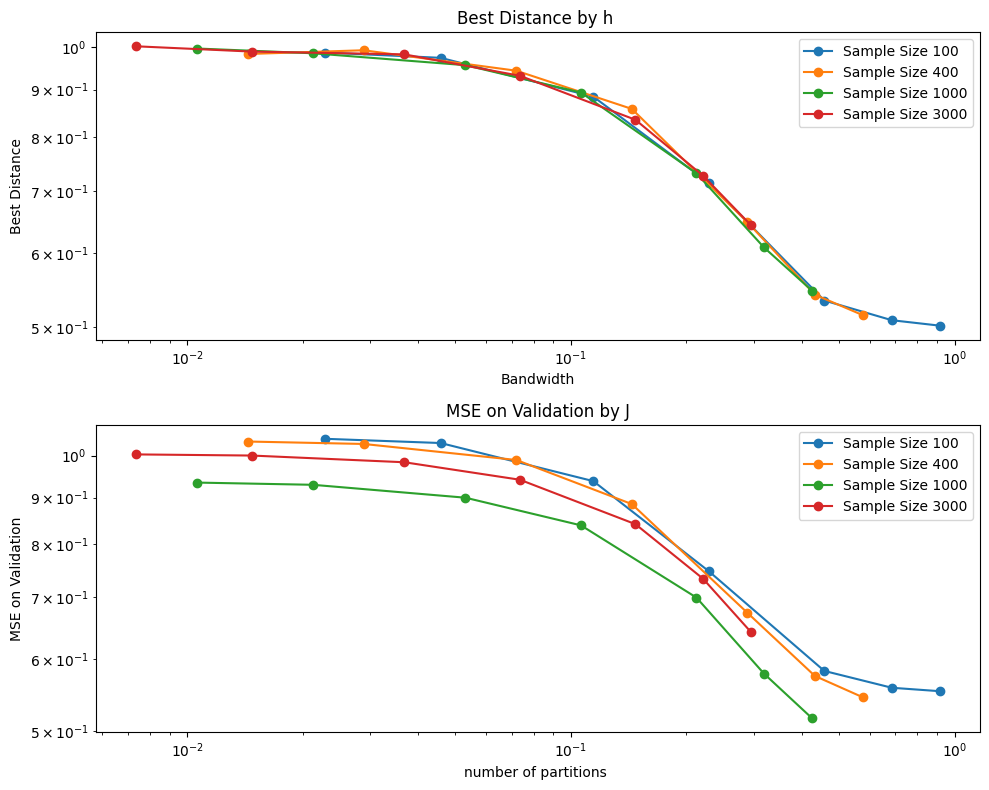

In [ ]:
result_table_h = []
fig, ax = plt.subplots(2, 1, figsize=(10,8))
for n in sample_sizes_ct:
    results = {}
    B=1
    m=np.sqrt(2*np.pi)
    true_theoretical_h = (3/(m*n*B))**(1/3)
    h_list = [ (true_theoretical_h * scale) for scale in scale_list if round(true_theoretical_h * scale) < n*(1-validation_size)]
    h_list = np.unique(h_list)
    h_list=h_list[h_list != 0]
    print('true_theoretical_h',true_theoretical_h,'h_list',h_list)
    best_mse = float('inf')
    best_h = float('inf')
    x = np.random.rand(n,1)
    eps = np.random.normal(0,sigma**2, n)
    f_star = lambda x_ : np.sin(2*np.pi*x_.ravel())
    y = f_star(x) + eps
    x, x_validation, y, y_validation = train_test_split(x, y, test_size=validation_size)
    best_mses = []
    best_hyperparams = []
    for h in h_list:
        time_start = time.time()
        fh_validation = kernel_estimator(x, y, x_validation, h)
        mse = MSE(fh_validation, x_validation, y_validation)
        time_end = time.time()
        T = time_end-time_start
        distance = distance_function_kernel(x, y, h, f_star, 1000)
        if mse < best_mse:
            best_mse = mse
            best_h = h
        c_t = T / (n**2)
        results[h] = distance
        result_table_h.append({
            "Sample Size": n,
            "Partition Size": h,
            "Best h": best_h,
            "T": T,
            "c_t": c_t,
            "Distance": distance,
            "MSE": mse,
        })
        best_mses.append(mse)
        best_hyperparams.append(h)
    h_values = list(results.keys())
    distances = list(results.values())
    min_h = min(results, key=results.get)
    min_distance = results[min_h]
    #print(f"For sample size {n}, h_t : {true_theoretical_h}, h_p= {min_h}, min distance = {min_distance} ")
    ax[0].loglog(h_values, distances, marker='o', label=f'Sample Size {n}')
    ax[1].loglog(best_hyperparams, best_mses, marker='o', label=f'Sample Size {n}')

ax[0].set_xlabel('Bandwidth')
ax[0].set_ylabel('Best Distance')
ax[0].set_title('Best Distance by h ')
ax[0].legend()
ax[1].set_xlabel('number of partitions ')
ax[1].set_ylabel('MSE on Validation')
ax[1].set_title('MSE on Validation by J')
ax[1].legend()
plt.tight_layout()
plt.show()
result_table_h = pd.DataFrame(result_table_h).sort_values('Sample Size')

In [ ]:
result_table_h['c_t']
h_factor = np.mean(c_t)
print(h_factor)
Time_budget = 1
New_scale_listh = [Time_budget /(h_factor  * (n**2)) for  n in sample_sizes]
print(New_scale_listh)
print(len(New_scale_listh))

5.3214761945936415e-09
[1879177.8135096251, 208797.5348344028, 18791.77813509625, 2087.975348344028, 187.9177813509625, 20.87975348344028, 1.879177813509625, 0.2087975348344028, 0.018791778135096252]
9


n 300
not_so_theoretical_h 0.27120229273349933
length of h lsit 2087
n 1000
not_so_theoretical_h 0.1815517508936346
length of h lsit 187
n 3000
not_so_theoretical_h 0.12588095336019947
length of h lsit 20
n 10000
not_so_theoretical_h 0.08426885796707431
length of h lsit 1
n 30000
not_so_theoretical_h 0.05842876274812329
length of h lsit 0
n 100000
not_so_theoretical_h 0.03911413901612734
length of h lsit 0


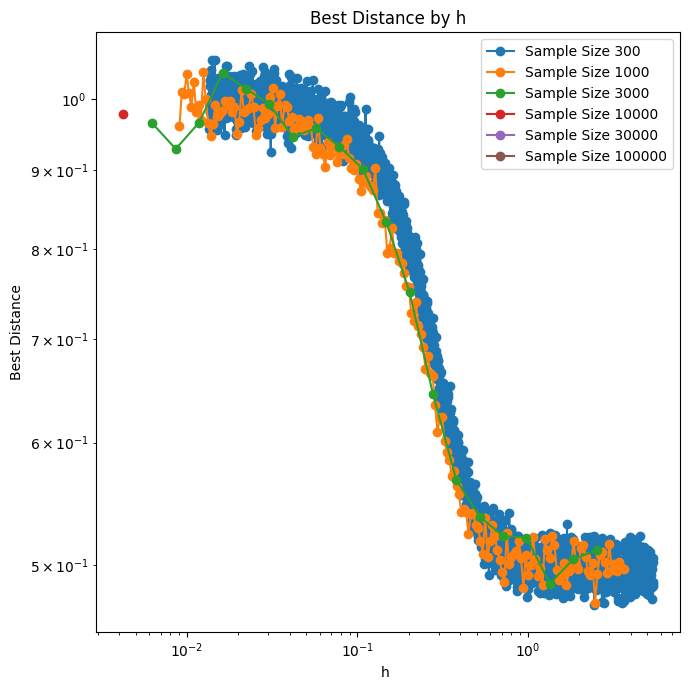

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
for idx, n in enumerate(sample_sizes[3:]):
    print('n',n)
    x = np.random.rand(n,1)
    eps = np.random.normal(0,sigma**2, n)
    f_star = lambda x_ : np.sin(2*np.pi*x_.ravel())
    y = f_star(x) + eps
    x, x_validation, y, y_validation = train_test_split(x, y, test_size=validation_size)
    scale_ = int(New_scale_listh[3+idx])
    results = {}
    B=0.2
    m=np.sqrt(2*np.pi)
    not_so_theoretical_h =  (3/(m*n*B))**(1/3)
    print('not_so_theoretical_h',not_so_theoretical_h)
    kernel_estimator(x, y, x_validation, not_so_theoretical_h)
    h_list_log = np.linspace(-3+np.log(not_so_theoretical_h) ,3+np.log(not_so_theoretical_h),num=scale_)
    h_list = np.exp(h_list_log)
    print('length of h lsit',len(h_list))
    best_mse = float('inf')
    best_mses = []
    best_hyperparams = []
    for h in h_list:
        fh_validation = kernel_estimator(x, y, x_validation, h)
        mse = MSE(fh_validation, x_validation, y_validation)
        T = time_end - time_start
        distance = distance_function_kernel(x, y, h, f_star, 1000)
        if mse < best_mse:
            best_mse = mse
            best_p = h
        results[h] = distance
        best_mses.append(mse)
        best_hyperparams.append(h)
    h_values = list(results.keys())
    distances = list(results.values())
    ax.loglog(h_values, distances, marker='o', label=f'Sample Size {n}')
ax.set_xlabel('h ')
ax.set_ylabel('Best Distance')
ax.set_title('Best Distance by h')
ax.legend()
plt.tight_layout()
plt.show()
